In [1]:
import cv2

from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import glob
import natsort
import csv

In [13]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(pulserate, band[0]), band[1])

# Rppg 신호측정

## 1. Face
- 이미지로 부터 RPPG 신호 측정

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_1_0.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_2_0.03333329999819398.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_3_0.06666669999808073.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_4_0.1.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_5_0.133333299998194.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_6_0.16666669999808073.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_7_0.2.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_8_0.233333299998194.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_9_0.26666669999808074.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_81_2.6666666999980806.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_82_2.7.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_83_2.733333299998194.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_84_2.7666666999980807.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_85_2.8000000000000003.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_86_2.833333299998194.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_87_2.8666666999980808.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_88_2.9.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_89_2.933333299998194.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_

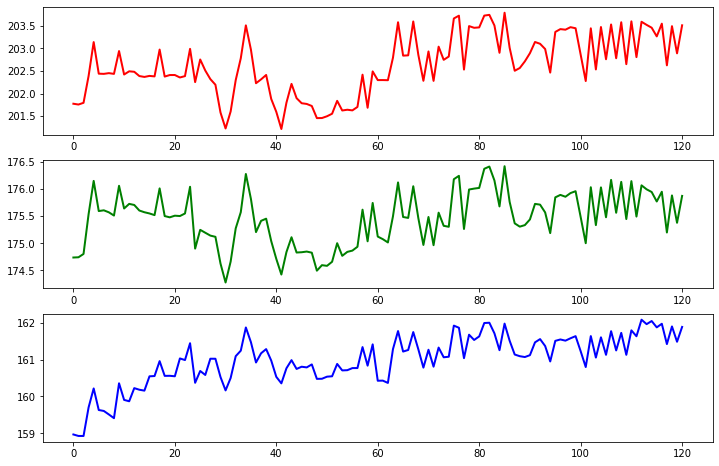

In [96]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')

times=[]
group=[]

#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

subject=0
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\100\\"
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

try:
    for file in file_list:
        # group 설정
        g=file.split('\\')[-1].split('_')[1]
        group.append(g)
        # time 설정
        t=file.split('\\')[-1].split('_')[-1][:-4]
        times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)

        # 현재 프레임에서 얼굴 검출하기
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
        detector.setInput(blob)
        detections = detector.forward()
        print(detections.shape)

        h, w = frame.shape[:2]
        bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
        if len(bboxes) > 0:
            # bbox가 존재한다면!
            bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
            bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
            curr_bbox = bboxes[0] # 얼굴 위치
            prev_bbox = curr_bbox
        else:
            # 존재하지 않는다면 즉, 얼굴 검출이 잘 안됐다면
            curr_bbox = prev_box

        # 얼굴 영역만 잘라내기
        face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]

        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(face)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

        # 얼굴 검출 시각화하기
        cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
    print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

pulse length:  (121,)


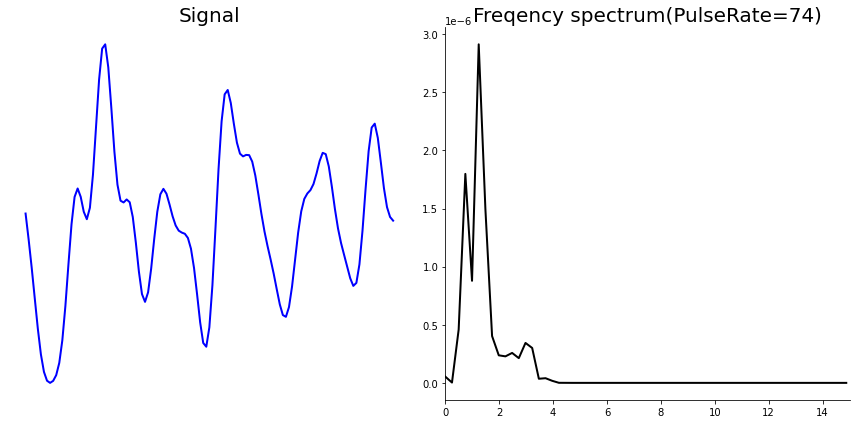

In [97]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

# file_num=subject
# save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
# f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
# wr = csv.writer(f)
# wr.writerow(pulse)
# wr.writerow(times)
# wr.writerow(group)
# f.close()

## 2. ARM RPPG

## 팔영역검출

#### 1. ycbcr로 피부영역검출

In [92]:
# frame = cv2.imread("./WIN_20210722_16_40_08_Pro.jpg", cv2.IMREAD_COLOR)
# ycbcr_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
# lower = np.array([0,150,50], dtype="uint8")
# upper = np.array([255,173,127], dtype="uint8")
# skin_img = cv2.inRange(ycbcr_frame, lower, upper)
# print(skin_img.shape)
# img_hand=skin_img
# print(img_hand)
# for i in range(skin_img.shape[0]):
#     for j in range(skin_img.shape[1]):
#         if img_hand[i][j]==255:
#             if 550<=j<=750 and 0<=i<=350 :
#                 img_hand[i][j]=0
#                 print("i,j",img_hand[i][j])
                
# cv2.rectangle(img_hand, (750,350), (550, 180), (255,0,0), 2)
# cv2.imshow('img',img_hand)
# cv2.imshow('skinimg',skin_img)
# while True :
#     if cv2.waitKey(0) == 27 :
#         cv2.destroyWindow('img')
#         cv2.destroyWindow('skinimg')
#         break;

#### 2. YCBCR에서 fill flood 알고리즘을 사용하여 팔영역만 추출

In [10]:
#ycbcr
def fill(data, start_coords, fill_value):

    xsize= data.shape[0]
    ysize=data.shape[1]
    orig_CR = data[start_coords[0], start_coords[1]][1]
    orig_CB = data[start_coords[0], start_coords[1]][2] 
    #print("orig",orig_CR, orig_CB) # Y, CR, CB
    stack = set(((start_coords[0], start_coords[1]),))
    
    if fill_value[0] == orig_CR and fill_value[1] == orig_CB:
        raise ValueError("Filling region with same value "
                     "already present is unsupported. "
                     "Did you already fill this region?")

    while stack:
        x, y = stack.pop()
        CR=data[x, y][1]
        CB=data[x, y][2]
        if 130<=CR<=173 and 50<=CB<=127:
            #print('fill_x: ',x,'fill_y: ',y)
            
            ROI_x.append(x)
            ROI_y.append(y)
            
            data[x, y][1] = fill_value[0]
            data[x, y][2] = fill_value[1]
            if x > 0:
                stack.add((x - 1, y))
            if x < (xsize - 1):
                stack.add((x + 1, y))
            if y > 0:
                stack.add((x, y - 1))
            if y < (ysize - 1):
                stack.add((x, y + 1))
    data=cv2.rectangle(data,(min(ROI_y),min(ROI_x)),(max(ROI_y),max(ROI_x)),(0,0,255),3)
    cv2.imshow('fill',data)
    return ROI_x,ROI_y

def click_event(event, x, y, flags, param):
    global ROI_x,ROI_y
    if event == cv2.EVENT_LBUTTONDOWN:
        ROI_x=[]
        ROI_y=[]
        #print('x: ',x,'y: ',y)
        print(ycbcr_frame[y][x],frame[y][x])
        ROI_x,ROI_y=fill(ycbcr_frame,[y,x],[0,0]) # BGR
        
def find_arm(y_crcb_img):
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',click_event)

    while(1):
        cv2.imshow('image',y_crcb_img)
        if cv2.waitKey(0) == 27 :
            break
    cv2.destroyAllWindows()

# # 팔검출 확인
# RGB_frame = cv2.imread("D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\100\\frame_1_0.0.png", cv2.IMREAD_COLOR)
# ycbcr_frame = cv2.cvtColor(RGB_frame,cv2.COLOR_BGR2YCR_CB)
# # 1. 팔영역 ROI찾기
# find_arm(ycbcr_frame)
# # ROI 이미지 크롭, 팔빼고 black처리
# ROI=list(zip(ROI_x,ROI_y))
# for i in range(min(ROI_x),max(ROI_x),1):
#     for j in range(min(ROI_y),max(ROI_y),1):
#         if (i,j)not in ROI:
#             RGB_frame[i][j]=0

# arm=RGB_frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
# while(1):
#     cv2.imshow('arm',arm)
#     if cv2.waitKey(0) == 27 :
#         break
# cv2.destroyAllWindows()

#### 3. 마우스로 ROI 직접 지정.

In [26]:
def click_event(event, x, y, flags, param):
    global xmin, ymin, drawing, img, ROI_img, drawing_flag

    if event == cv2.EVENT_LBUTTONDOWN:  # 마우스를 누른 상태
        drawing = True
        xmin, ymin = x, y

    elif event == cv2.EVENT_MOUSEMOVE:  # 마우스 이동
        if drawing == True:  # 마우스를 누른 상태 일경우
            img_temp = img.copy()
            cv2.rectangle(img_temp, (xmin, ymin), (x, y), (0, 0, 255), 1)
            cv2.imshow('image', img_temp)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False  # 마우스를 때면 상태 변경
        
        cv2.rectangle(img, (xmin, ymin), (x, y), (0, 0, 255), 1)
        cv2.imshow('image', img)
        ROI_img=img[ymin:y,xmin:x]
        cv2.imshow('ROI img',ROI_img)
        print('xmin :{}, ymin:{}, xmax:{}, ymax:{}'.format(xmin, ymin, x, y))
        drawing_flag = True
        
def find_arm(img):
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',click_event)

    while(1):
        cv2.imshow('image',img)
        if cv2.waitKey(0) == 27 :
            break
    cv2.destroyAllWindows()

    

file_num=100    
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\100\\"
save_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\100\\"

file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

drawing=False
for (i,file) in enumerate(file_list):
    print("file_name",file)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    find_arm(img)
    cv2.imwrite(save_path+str(i)+'.png',ROI_img)

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_1_0.0.png
xmin :143, ymin:345, xmax:178, ymax:459
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_2_0.03333329999819398.png
xmin :142, ymin:354, xmax:176, ymax:462
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_3_0.06666669999808073.png
xmin :143, ymin:353, xmax:173, ymax:486
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_4_0.1.png
xmin :141, ymin:356, xmax:176, ymax:470
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_5_0.133333299998194.png
xmin :140, ymin:358, xmax:175, ymax:460
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_6_0.16666669999808073.png
xmin :138, ymin:371, xmax:178, ymax:467
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_7_0.2.png
xmin :137, ymin:367, xmax:181, ymax:461
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_8_0.233333299998194.png
xmin :135, ymin:368,

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


xmin :136, ymin:364, xmax:179, ymax:466
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_16_0.5.png
xmin :140, ymin:353, xmax:178, ymax:462
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_17_0.533333299998194.png
xmin :140, ymin:355, xmax:170, ymax:457
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_18_0.5666666999980807.png


error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


xmin :133, ymin:363, xmax:183, ymax:472
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_19_0.6.png
xmin :132, ymin:370, xmax:179, ymax:466
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_20_0.633333299998194.png
xmin :138, ymin:370, xmax:180, ymax:462
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_21_0.6666666999980807.png
xmin :137, ymin:371, xmax:180, ymax:467
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_22_0.7000000000000001.png
xmin :137, ymin:366, xmax:176, ymax:464
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_23_0.733333299998194.png
xmin :135, ymin:375, xmax:177, ymax:472
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_24_0.7666666999980808.png
xmin :133, ymin:370, xmax:175, ymax:467
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_25_0.8.png
xmin :133, ymin:374, xmax:177, ymax:464
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\im

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_82_2.7.png
xmin :137, ymin:363, xmax:174, ymax:461
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_83_2.733333299998194.png
xmin :132, ymin:378, xmax:174, ymax:461
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_84_2.7666666999980807.png
xmin :133, ymin:375, xmax:176, ymax:463
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_85_2.8000000000000003.png
xmin :129, ymin:373, xmax:182, ymax:461
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_86_2.833333299998194.png
xmin :133, ymin:374, xmax:179, ymax:460
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_87_2.8666666999980808.png
xmin :133, ymin:381, xmax:179, ymax:467
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_88_2.9.png
xmin :131, ymin:381, xmax:178, ymax:466
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\100\frame_89_2.933333299998194.png
x

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\0.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\1.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\2.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\3.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\4.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\5.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\6.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\7.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\8.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\9.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\10.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\11.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\12.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\100\13.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\1

==================================================!!!finish!!!=================================================


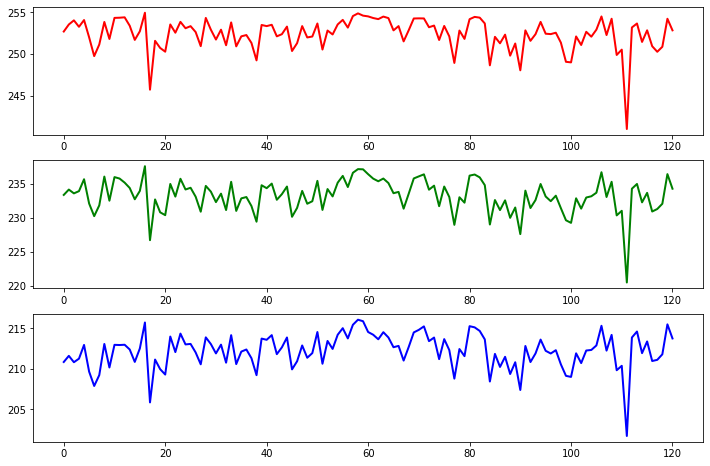

In [28]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')

times=[]
group=[]

#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

subject=0
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\100"
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

try:
    for file in file_list:
#         # group 설정
#         g=file.split('\\')[-1].split('_')[1]
#         group.append(g)
#         # time 설정
#         t=file.split('\\')[-1].split('_')[-1][:-4]
#         times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)
#         ycbcr_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
        
#         # 1. 팔영역 ROI찾기
#         find_arm(ycbcr_frame)
        
#         # 2. # ROI 이미지 크롭, 팔빼고 black처리
#         ROI=list(zip(ROI_x,ROI_y))
#         for i in range(min(ROI_x),max(ROI_x),1):
#             for j in range(min(ROI_y),max(ROI_y),1):
#                 if (i,j)not in ROI:
#                     frame[i][j]=0
                    
#         # 3. arm이미지 추출
#         arm=RGB_frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
        
        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(frame)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각 신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

#         # 얼굴 검출 시각화하기
#         cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
#         cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
    print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

pulse length:  (121,)


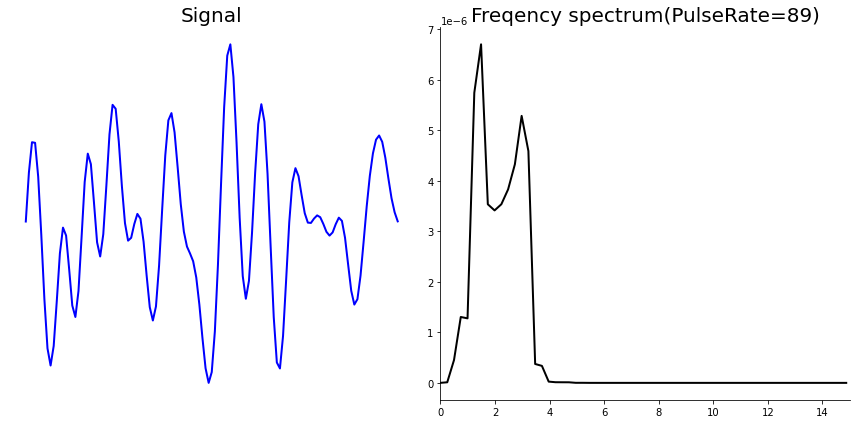

In [29]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

# file_num=subject
# save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
# f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
# wr = csv.writer(f)
# wr.writerow(pulse)
# wr.writerow(times)
# wr.writerow(group)
# f.close()